In [17]:
import pandas as pd

# Load your prediction CSV
pred = pd.read_csv("epic100_validation_predictions_epoch13_v3.csv")

# Load EPIC's validation annotation CSV (not label CSV)
val = pd.read_csv("EPIC_100_validation_label.csv")

# Select only needed columns from val
val = val[["narration_id", "participant_id", "video_id", "start_frame", "stop_frame"]]

# Merge on narration_id + participant_id + video_id
merged = pd.merge(
    pred,
    val,
    on=["narration_id", "participant_id", "video_id"],
    how="inner"
)

# Reorder columns exactly as you want
merged = merged[
    [
        "narration_id",
        "participant_id",
        "video_id",
        "start_frame",
        "stop_frame",
        "pred_verb_class",
        "pred_noun_class",
        "pred_verb",
        "pred_noun"
    ]
]

# Save final merged CSV
merged.to_csv("epic100_validation_predictions_final_v3.csv", index=False)

print("[INFO] Saved → epic100_validation_predictions_with_frames.csv")


[INFO] Saved → epic100_validation_predictions_with_frames.csv


In [18]:
import pandas as pd


pred = pd.read_csv("epic100_validation_predictions_final_v3.csv")
val = pd.read_csv("EPIC_100_validation_label.csv")

val = val[[
    "narration_id",
    "participant_id",
    "video_id",
    "start_frame",
    "stop_frame",
    "noun_class"
]]

merged = pd.merge(
    pred,
    val,
    on=["narration_id", "participant_id", "video_id", "start_frame", "stop_frame"],
    how="inner"
)


merged["noun_correct"] = merged["pred_noun_class"] == merged["noun_class"]

num_correct = merged["noun_correct"].sum()
total = len(merged)
accuracy = num_correct / total if total > 0 else 0

print(f"Correct noun predictions: {num_correct}/{total}")
print(f"Noun class accuracy: {accuracy:.4f}")


Correct noun predictions: 2003/9668
Noun class accuracy: 0.2072


In [19]:
import pandas as pd

# Load prediction + validation CSVs
pred = pd.read_csv("epic100_validation_predictions_final_v3.csv")
val = pd.read_csv("EPIC_100_validation_label.csv")

# Keep noun + class info from validation file
val = val[[
    "narration_id",
    "participant_id",
    "video_id",
    "start_frame",
    "stop_frame",
    "noun",
    "noun_class"
]]

# Merge predictions with validation labels
merged = pd.merge(
    pred,
    val,
    on=["narration_id", "participant_id", "video_id", "start_frame", "stop_frame"],
    how="inner"
)

# Whether noun prediction is correct
merged["noun_correct"] = merged["pred_noun_class"] == merged["noun_class"]

# ---- Compute accuracy per noun ----
noun_stats = merged.groupby(["noun_class", "noun"])["noun_correct"].agg(
    correct="sum",
    total="count"
)

noun_stats["accuracy"] = noun_stats["correct"] / noun_stats["total"]

# Clean final table
noun_stats = noun_stats.reset_index().sort_values(by="accuracy", ascending=False)

print(noun_stats)


     noun_class              noun  correct  total  accuracy
26            3            locker        1      1       1.0
233          31          oil:more        1      1       1.0
348          54       bit:garbage        1      1       1.0
401          65  temperature:oven        1      1       1.0
7             1        spade:food        1      1       1.0
..          ...               ...      ...    ...       ...
663         274          cinnamon        0      1       0.0
664         278       level:power        0      1       0.0
665         282             sheet        0      1       0.0
666         288             mouse        0      2       0.0
584         163             bacon        0     10       0.0

[668 rows x 5 columns]


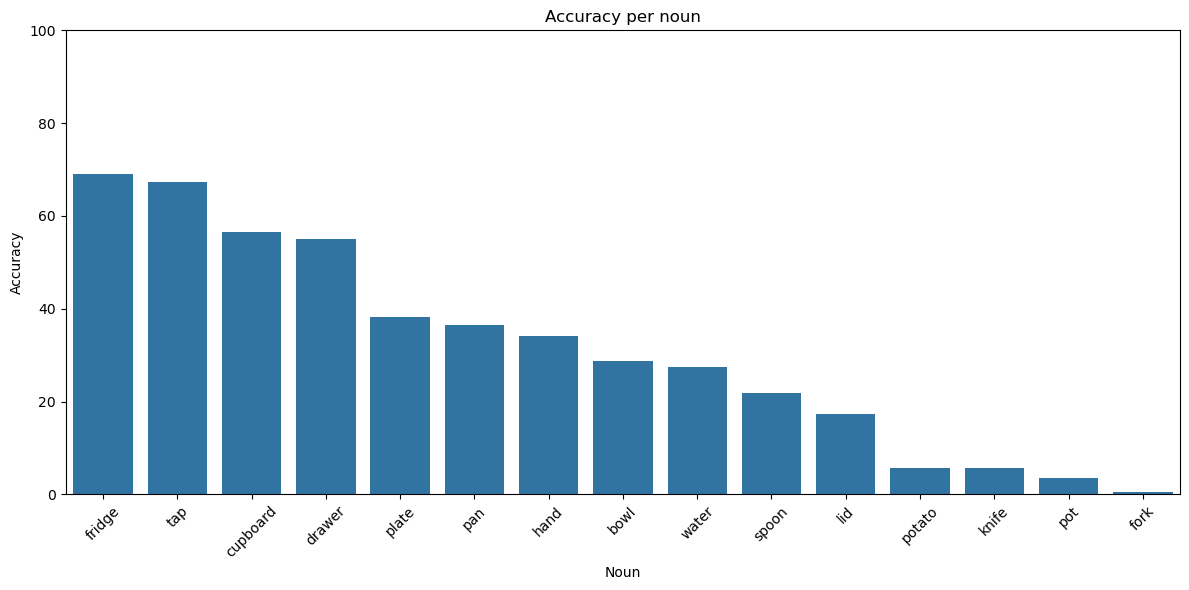

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load validation labels and predictions
pred = pd.read_csv("epic100_validation_predictions_final_v3.csv")
val = pd.read_csv("EPIC_100_validation_label.csv")

# Keep relevant columns
val = val[["narration_id", "participant_id", "video_id", "start_frame", "stop_frame", "noun", "noun_class"]]

# Merge predictions with validation labels
merged = pd.merge(
    pred,
    val,
    on=["narration_id", "participant_id", "video_id", "start_frame", "stop_frame"],
    how="inner"
)

# Check noun correctness
merged["noun_correct"] = merged["pred_noun_class"] == merged["noun_class"]

# Compute accuracy per noun
noun_stats = merged.groupby(["noun_class", "noun"])["noun_correct"].agg(
    correct="sum",
    total="count"
)
noun_stats["accuracy"] = (noun_stats["correct"] *100) / noun_stats["total"]
noun_stats = noun_stats.reset_index()

# Find top 15 most common nouns in validation
top15_nouns = val['noun'].value_counts().head(15).index
top15_stats = noun_stats[noun_stats['noun'].isin(top15_nouns)]

# Sort for better visualization
top15_stats = top15_stats.sort_values(by="accuracy", ascending=False)

# Plot with default blue color
plt.figure(figsize=(12,6))
sns.barplot(x="noun", y="accuracy", data=top15_stats)  # default color
plt.title("Accuracy per noun")
plt.ylabel("Accuracy")
plt.xlabel("Noun")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd


pred = pd.read_csv("epic100_validation_predictions_final_v3.csv")

val = pd.read_csv("EPIC_100_validation_label.csv")

val = val[[
    "narration_id",
    "participant_id",
    "video_id",
    "start_frame",
    "stop_frame",
    "verb_class"
]]

merged = pd.merge(
    pred,
    val,
    on=["narration_id", "participant_id", "video_id", "start_frame", "stop_frame"],
    how="inner"
)

print(f"[INFO] Merged rows: {len(merged)}")

merged["verb_correct"] = merged["pred_verb_class"] == merged["verb_class"]

num_correct = merged["verb_correct"].sum()
total = len(merged)
accuracy = num_correct / total if total > 0 else 0

print(f"Correct noun predictions: {num_correct}/{total}")
print(f"verb class accuracy: {accuracy:.4f}")


[INFO] Merged rows: 9668
Correct noun predictions: 3806/9668
verb class accuracy: 0.3937


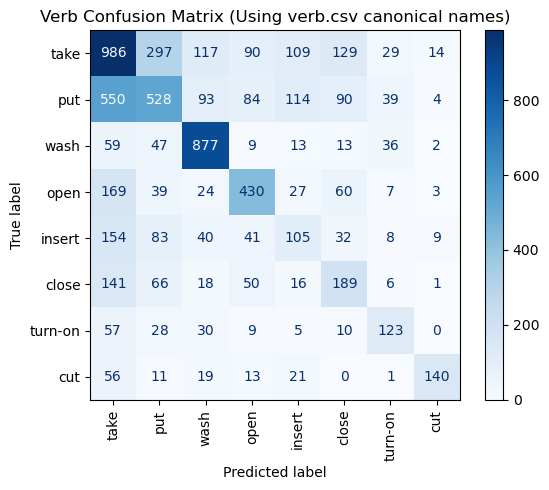

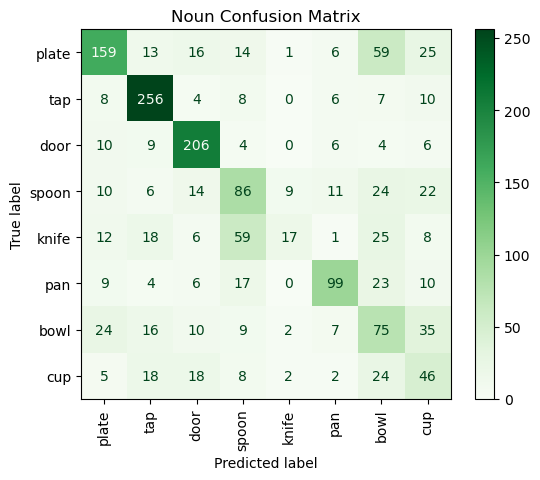

In [22]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the CSV files
ground_truth = pd.read_csv("epic100_validation_predictions_final_v3.csv")
predictions = pd.read_csv("EPIC_100_validation_label.csv")
verbs = pd.read_csv("verb.csv")

# Merge on narration_id
df = ground_truth.merge(predictions, on='narration_id')

# Function to get top N most frequent classes
def top_n_classes(column, n=8):
    return column.value_counts().nlargest(n).index.tolist()

# ---- Verb ----
top_verbs = top_n_classes(df['verb_class'], 8)

# Filter only the top verb classes
df_verbs = df[
    df['verb_class'].isin(top_verbs) &
    df['pred_verb_class'].isin(top_verbs)
]

# Create mapping from verb_class → canonical verb name
verb_mapping = verbs.set_index("id")["key"].to_dict()

# Convert top verb class IDs into verb names
top_verbs_names = [verb_mapping[v] for v in top_verbs]

# Build confusion matrix
verb_cm = confusion_matrix(
    df_verbs['verb_class'],
    df_verbs['pred_verb_class'],
    labels=top_verbs
)

verb_disp = ConfusionMatrixDisplay(
    confusion_matrix=verb_cm,
    display_labels=top_verbs_names
)

verb_disp.plot(
    cmap='Blues',
    xticks_rotation='vertical',
    values_format='d',
    colorbar=True
)
verb_disp.ax_.set_title('Verb Confusion Matrix (Using verb.csv canonical names)')

# ---- Noun ----
top_nouns = top_n_classes(df['noun_class'], 8)
df_nouns = df[df['noun_class'].isin(top_nouns) & df['pred_noun_class'].isin(top_nouns)]

# Mapping noun_class -> noun name
noun_mapping = df.set_index('noun_class')['noun'].to_dict()
top_nouns_names = [noun_mapping[n] for n in top_nouns]

noun_cm = confusion_matrix(df_nouns['noun_class'], df_nouns['pred_noun_class'], labels=top_nouns)
noun_disp = ConfusionMatrixDisplay(confusion_matrix=noun_cm, display_labels=top_nouns_names)
noun_disp.plot(cmap='Greens', xticks_rotation='vertical', values_format='d', colorbar=True)
noun_disp.ax_.set_title('Noun Confusion Matrix')

plt.show()


In [23]:
import pandas as pd

# Load train CSV
df = pd.read_csv("../data/annotations/EPIC_100_train.csv")

# Load verb CSV (contains id, key, ...)
verbs = pd.read_csv("verb.csv")

# Count top 20 verb classes
verb_counts = df['verb_class'].value_counts().head(10).reset_index()
verb_counts.columns = ['verb_class', 'count']

# Merge to get actual verb names (column 'key')
merged = pd.merge(verb_counts, verbs, left_on='verb_class', right_on='id', how='left')

# Keep only useful columns
final_table = merged[['verb_class', 'key', 'count']]

print(final_table)


   verb_class       key  count
0           0      take  14848
1           1       put  12225
2           2      wash   6927
3           3      open   4870
4           4     close   3483
5           5    insert   3016
6           6   turn-on   2293
7           8  turn-off   1861
8           7       cut   1742
9          11      move   1652
